# Darknet Traffic Classification using Federated Semi-Supervised Learning

## Rancangan Sistem

Penelitian ini mengimplementasikan pendekatan Federated Semi-Supervised Learning untuk klasifikasi traffic Darknet. Berikut adalah rancangan sistem yang digunakan:

### 1. Komponen-komponen Sistem

**A. Node Server (Aggregator)**
- **Perangkat**: Security Operations Center (SOC) server
- **Fungsi**:
  - Menginisiasi proses federated learning
  - Mengagregasi model dari clients
  - Mendistribusikan model global yang diperbarui
- **Algoritma**: Federated Averaging (FedAvg)

**B. Node Client**
- **Perangkat**:
  1. Router Edge/Gateway di berbagai cabang organisasi
  2. Intrusion Detection System (IDS) nodes
  3. Next-Generation Firewalls
  4. Network Monitoring Tools
- **Fungsi**:
  - Mengumpulkan traffic data lokal
  - Melatih model lokal menggunakan semi-supervised learning
  - Mengirim parameter model ke server
- **Algoritma**:
  - Self-Training dengan threshold confidence untuk pseudo-labeling
  - RandomForest/Neural Network untuk model dasar

### 2. Alur Proses

1. **Inisialisasi**:
   - Server mengirimkan model dasar awal ke semua clients
   - Pengaturan parameter threshold confidence untuk pseudo-labeling

2. **Pada Setiap Client**:
   - **Preprocessing**: Ekstraksi fitur dan normalisasi
   - **Semi-supervised Learning**:
     - Melatih model lokal pada data berlabel
     - Menghasilkan pseudo-labels untuk data tidak berlabel
     - Melatih ulang model dengan data kombinasi

3. **Komunikasi & Agregasi**:
   - Clients mengirim parameter model ke server
   - Server mengagregasi parameter untuk membuat model global
   - Server mengirim model global yang diperbarui ke semua clients

4. **Evaluasi & Deteksi**:
   - Model final diterapkan untuk klasifikasi real-time
   - Evaluasi performa pada data pengujian

### 3. Simulasi dalam Penelitian Ini

Dalam penelitian ini, sistem federated learning disimulasikan menggunakan Google Colab dengan dataset CIC-Darknet2020. Meskipun dataset ini memiliki label lengkap, untuk mensimulasikan kondisi dunia nyata dimana labeling traffic jaringan secara lengkap sangat sulit dicapai, penelitian ini:

1. Secara sengaja 'menghapus' label dari sebagian besar dataset (70-80%)
2. Memperlakukannya sebagai data tidak berlabel
3. Membagi dataset ke beberapa "klien virtual" untuk mensimulasikan distribusi data dalam environment federated learning

Simulasi ini memungkinkan evaluasi yang realistis tentang bagaimana metode yang diusulkan akan berperforma dalam lingkungan operasional nyata dengan keterbatasan data berlabel.

## Rancangan Eksperimen

Untuk mengevaluasi pendekatan Federated Semi-Supervised Learning dalam klasifikasi traffic Darknet, beberapa eksperimen akan dilakukan:

### Eksperimen 1: Pengaruh Rasio Data Berlabel
- Variasi rasio data berlabel: 10%, 20%, 30%, 50%
- Evaluasi: Accuracy, F1-score, dan learning curve

### Eksperimen 2: Dampak Jumlah Clients
- Variasi jumlah clients: 5 dan 10 clients
- Evaluasi: Model convergence dan komunikasi overhead

### Eksperimen 3: Non-IID vs IID Data Distribution
- Skenario distribusi data yang berbeda antar client
- Evaluasi: Robustness model terhadap heterogenitas data

### Eksperimen 4: Adaptabilitas Terhadap Pola Traffic Baru
- Simulasi domain shift dengan menambahkan jenis traffic baru
- Evaluasi: Adaptation time dan performance retention

### Metrik Evaluasi
1. **Performa Dasar**: Accuracy, Precision, Recall, F1-score, AUC-ROC
2. **Adaptabilitas**: Transfer adaptability score, kontinuitas pembelajaran
3. **Robustness**: Performa pada distribusi kelas yang berubah
4. **Sistem Federated**: Communication overhead, convergence rate

In [ ]:
# 1. Preprocessing Data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from torch.utils.data import DataLoader, TensorDataset
import time

# Memuat dataset
dataset = pd.read_csv("Darknet.csv", sep=",", on_bad_lines='warn')

# Mengganti nilai inf dan -inf dengan NaN dan mengisi dengan median
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
numerical_columns = dataset.select_dtypes(include=[np.number]).columns
dataset[numerical_columns] = dataset[numerical_columns].fillna(dataset[numerical_columns].median())

print("Missing Values per Kolom setelah pembersihan:")
print(dataset.isnull().sum())

# Mengecek distribusi label
print("\nNilai Unik di Kolom 'Label':")
print(dataset['Label'].unique())

# Memisahkan data berlabel dan tidak berlabel (simulasi)
# Untuk simulasi kondisi dunia nyata dimana labeling terbatas,
# kita menghapus label dari sebagian data
labeled_data = dataset.copy()
unlabeled_indices = labeled_data.sample(frac=0.7, random_state=42).index  # 70% data dianggap tidak berlabel
unlabeled_data = labeled_data.loc[unlabeled_indices].copy()
# Simpan label sebenarnya untuk evaluasi
true_unlabeled_labels = unlabeled_data['Label'].copy()
unlabeled_data['Label'] = None  # Hapus label untuk mensimulasikan data tidak berlabel
labeled_data = labeled_data.drop(unlabeled_indices)

print(f"\nJumlah data yang diberi label: {len(labeled_data)}")
print(f"Jumlah data yang tidak diberi label: {len(unlabeled_data)}")

# Simpan data untuk penggunaan nanti
labeled_data.to_csv('labeled_data.csv', index=False)
unlabeled_data.to_csv('unlabeled_data.csv', index=False)
pd.Series(true_unlabeled_labels).to_csv('true_unlabeled_labels.csv', index=False, header=['Label'])

<ipython-input-1-d55137d95836>:20: ParserWarning: Skipping line 328: expected 85 fields, saw 125

  dataset = pd.read_csv("Darknet.csv", sep=",", on_bad_lines='warn')


Missing Values per Kolom setelah pembersihan:
Flow ID     0
Src IP      0
Src Port    0
Dst IP      0
Dst Port    0
           ..
Idle Std    0
Idle Max    0
Idle Min    0
Label       0
Label.1     0
Length: 85, dtype: int64

Nilai Unik di Kolom 'Label':
['Non-Tor' 'NonVPN' 'Tor' 'VPN']

Jumlah data yang diberi label: 42459
Jumlah data yang tidak diberi label: 99071


In [ ]:
# 2. Fungsi Utilitas untuk Federated Semi-Supervised Learning

def prepare_features(data, non_feature_cols=['Label', 'Label.1', 'Flow ID', 'Src IP', 'Dst IP', 'Timestamp']):
    """Mempersiapkan fitur dari dataset, menghapus kolom non-fitur"""
    features = data.drop(columns=non_feature_cols, errors='ignore')

    # Transformasi kategorikal ke numerik
    cat_cols = features.select_dtypes(include=['object']).columns
    for col in cat_cols:
        le = LabelEncoder()
        features[col] = le.fit_transform(features[col])

    return features

def preprocess_data(features):
    """Normalisasi fitur dan tangani nilai ekstrem/NaN"""
    # Mengatasi NaN dan inf
    features.replace([np.inf, -np.inf], np.nan, inplace=True)
    features = features.fillna(features.median())

    # Normalisasi
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    return scaled_features, scaler

def simulate_federated_clients_stratified(labeled_data, unlabeled_data, num_clients=10, seed=42):
    """
    Mensimulasikan multiple clients dengan membagi dataset
    secara non-IID (distribusi tidak seragam)
    """
    random.seed(seed)
    np.random.seed(seed)

    # Batas maksimum client
    num_clients = min(num_clients, 10)

    # 1. Stratifikasi data berlabel
    labeled_clients = []
    if 'Label' in labeled_data.columns:
        # Stratified split berdasarkan label
        from sklearn.model_selection import StratifiedKFold

        # Get labels
        labels = labeled_data['Label'].values

        # Use StratifiedKFold to create balanced splits
        skf = StratifiedKFold(n_splits=num_clients, shuffle=True, random_state=seed)

        # Split labeled data
        for _, idx in skf.split(labeled_data, labels):
            client_labeled = labeled_data.iloc[idx].copy()
            labeled_clients.append(client_labeled)
    else:
        # Kalau tidak ada label, bagi secara acak
        client_size = len(labeled_data) // num_clients
        for i in range(num_clients):
            if i < num_clients - 1:
                client_labeled = labeled_data.iloc[i*client_size:(i+1)*client_size].copy()
            else:
                client_labeled = labeled_data.iloc[i*client_size:].copy()
            labeled_clients.append(client_labeled)

    # 2. Bagi data unlabeled
    unlabeled_clients = []
    client_size = len(unlabeled_data) // num_clients
    for i in range(num_clients):
        if i < num_clients - 1:
            client_unlabeled = unlabeled_data.iloc[i*client_size:(i+1)*client_size].copy()
        else:
            client_unlabeled = unlabeled_data.iloc[i*client_size:].copy()
        unlabeled_clients.append(client_unlabeled)

    # Cetak statistik distribusi
    print("\nDistribusi Data per Client (Stratified):")
    for i, (labeled, unlabeled) in enumerate(zip(labeled_clients, unlabeled_clients)):
        print(f"Client {i+1}:")
        print(f"  Data berlabel: {len(labeled)}")
        print(f"  Data tidak berlabel: {len(unlabeled)}")
        if 'Label' in labeled.columns and len(labeled) > 0:
            print(f"  Distribusi label:")
            print(labeled['Label'].value_counts())
        print()

    return labeled_clients, unlabeled_clients


# Neural Network Model untuk Darknet Classification
class DarknetClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=4):
        super(DarknetClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

    def get_weights(self):
        """Return model weights as a list of numpy arrays"""
        return [p.cpu().detach().numpy() for p in self.parameters()]

    def set_weights(self, weights):
      """Memuat bobot ke model dan memastikan dimensi sesuai"""
      with torch.no_grad():
          # Mengonversi weights menjadi list terlebih dahulu
          weights = list(weights)  # Mengubah generator menjadi list

          # Convert self.parameters() to a list as well for length comparison
          model_params = list(self.parameters())

          # Mengecek apakah jumlah bobot cocok dengan jumlah parameter model
          if len(weights) != len(model_params):
              raise ValueError(f"Jumlah parameter model tidak cocok dengan bobot yang diberikan. "
                            f"Expected {len(model_params)}, got {len(weights)}")

          # Memastikan bahwa dimensi setiap bobot cocok dengan dimensi parameter model
          for i, p in enumerate(model_params):
              # Mengecek apakah dimensi tiap parameter sesuai dengan dimensi bobot
              if p.shape != weights[i].shape:
                  raise ValueError(f"Dimensi parameter {i} tidak cocok: "
                                f"Expected {p.shape}, got {weights[i].shape}")

              # Mengcopy bobot dari list ke parameter model
              p.copy_(torch.tensor(weights[i]))

In [ ]:
# 3. Implementasi Semi-Supervised Learning pada Client

def train_supervised(model, X_train, y_train, X_val=None, y_val=None, num_epochs=20, batch_size=64, lr=0.001):
    """Melatih model dengan supervised learning"""
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    if X_val is not None and y_val is not None:
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    train_losses = []
    val_accuracies = []

    # Buat DataLoader untuk batch processing
    train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        # Validasi
        if X_val is not None and y_val is not None:
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_tensor)
                _, val_preds = torch.max(val_outputs, 1)
                val_acc = accuracy_score(y_val_tensor.numpy(), val_preds.numpy())
                val_accuracies.append(val_acc)

            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Val Acc: {val_acc:.4f}")

    return model, train_losses, val_accuracies

def generate_pseudo_labels(model, X_unlabeled, confidence_threshold=0.8):
    """Generate pseudo-labels for unlabeled data with confidence filtering"""
    X_unlabeled_tensor = torch.tensor(X_unlabeled, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        outputs = model(X_unlabeled_tensor)
        probabilities = F.softmax(outputs, dim=1)
        max_probs, predicted_labels = torch.max(probabilities, dim=1)

        # Filter based on confidence
        confident_idx = (max_probs >= confidence_threshold).numpy()

        pseudo_labels = predicted_labels.numpy()
        confidence_scores = max_probs.numpy()

    return pseudo_labels, confidence_scores, confident_idx

def semi_supervised_learning(labeled_X, labeled_y, unlabeled_X, confidence_threshold=0.8,
                             num_iterations=3, hidden_dim=128, num_epochs=20):
    """Implement semi-supervised learning for a single client"""
    input_dim = labeled_X.shape[1]
    num_classes = len(np.unique(labeled_y))

    # Initialize model
    model = DarknetClassifier(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=num_classes)

    # Split labeled data for validation
    X_train, X_val, y_train, y_val = train_test_split(labeled_X, labeled_y, test_size=0.2, random_state=42)

    # First training on labeled data only
    print("Training initial model on labeled data only...")
    model, _, _ = train_supervised(model, X_train, y_train, X_val, y_val, num_epochs=num_epochs)

    # Iterative pseudo-labeling
    for i in range(num_iterations):
        print(f"\nIteration {i+1}/{num_iterations} of pseudo-labeling")

        # Generate pseudo-labels
        pseudo_labels, confidence, confident_idx = generate_pseudo_labels(
            model, unlabeled_X, confidence_threshold
        )

        # Filter by confidence
        confident_unlabeled_X = unlabeled_X[confident_idx]
        confident_pseudo_labels = pseudo_labels[confident_idx]

        print(f"Generated {len(confident_pseudo_labels)} confident pseudo-labels")

        if len(confident_pseudo_labels) == 0:
            print("No confident pseudo-labels generated. Continuing with current model.")
            continue

        # Combine labeled and pseudo-labeled data
        combined_X = np.vstack([X_train, confident_unlabeled_X])
        combined_y = np.concatenate([y_train, confident_pseudo_labels])

        # Train on combined data
        print(f"Training on combined data (labeled + pseudo-labeled)...")
        model, _, _ = train_supervised(model, combined_X, combined_y, X_val, y_val, num_epochs=num_epochs)

        # Optional: increase confidence threshold over iterations
        confidence_threshold = min(0.95, confidence_threshold + 0.05)

    return model

def client_training(client_id, labeled_data, unlabeled_data, global_model_weights=None):
    """Training process for a single client in federated learning"""
    print(f"\n=== Client {client_id+1} Training ===")

    # Prepare features and labels
    if len(labeled_data) > 0:
        X_labeled = prepare_features(labeled_data)
        y_labeled = labeled_data['Label'].values
        le = LabelEncoder()
        y_labeled = le.fit_transform(y_labeled)

        X_labeled, scaler = preprocess_data(X_labeled)
    else:
        print("Client has no labeled data. Skipping training.")
        return None, None

    if len(unlabeled_data) > 0:
        X_unlabeled = prepare_features(unlabeled_data)
        X_unlabeled = scaler.transform(X_unlabeled)
    else:
        X_unlabeled = np.array([]).reshape(0, X_labeled.shape[1])

    # Create and initialize model
    input_dim = X_labeled.shape[1]
    num_classes = len(np.unique(y_labeled))
    model = DarknetClassifier(input_dim=input_dim, hidden_dim=128, output_dim=num_classes)

    # Load global model weights if available
    if global_model_weights is not None:
        model.set_weights(global_model_weights)

    # Apply semi-supervised learning
    if len(X_unlabeled) > 0:
        model = semi_supervised_learning(X_labeled, y_labeled, X_unlabeled,
                                         confidence_threshold=0.8, num_iterations=2)
    else:
        # If no unlabeled data, just train on labeled data
        X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)
        model, _, _ = train_supervised(model, X_train, y_train, X_val, y_val)

    # Return trained model weights and the scaler
    return model.get_weights(), scaler

In [ ]:
# 4. Implementasi Federated Learning

def federated_averaging(client_weights, client_sizes):
    """Implement federated averaging untuk menggabungkan model klien"""
    # Validate input
    if len(client_weights) == 0:
        return None

    total_size = sum(client_sizes)
    if total_size == 0:
        return client_weights[0]

    # Initialize aggregated weights with zeros like the first client's weights
    aggregated_weights = [np.zeros_like(w) for w in client_weights[0]]

    # Weighted average based on client data size
    for i, weights in enumerate(client_weights):
        weight = client_sizes[i] / total_size
        for j, w in enumerate(weights):
            aggregated_weights[j] += w * weight

    return aggregated_weights

def fed_median(client_weights, client_sizes):
    """FedMedian: Agregasi berbasis nilai median untuk ketahanan terhadap poisoning"""
    # Validate input
    if len(client_weights) == 0:
        return None

    if len(client_weights) == 1:
        return client_weights[0]

    # Initialize aggregated weights with zeros like the first client's weights
    aggregated_weights = [np.zeros_like(w) for w in client_weights[0]]

    # For each layer
    for j in range(len(aggregated_weights)):
        # Collect weights from all clients for this layer
        layer_weights = [weights[j] for weights in client_weights]

        # Compute median along the first axis (clients)
        aggregated_weights[j] = np.median(layer_weights, axis=0)

    return aggregated_weights

def fed_trimmed_mean(client_weights, client_sizes, beta=0.2):
    """FedTrimmedMean: Agregasi dengan trimmed mean yang membuang ekstrem beta teratas dan terbawah"""
    # Validate input
    if len(client_weights) == 0:
        return None

    if len(client_weights) == 1:
        return client_weights[0]

    num_clients = len(client_weights)
    num_to_trim = max(1, int(beta * num_clients))

    # Initialize aggregated weights with zeros like the first client's weights
    aggregated_weights = [np.zeros_like(w) for w in client_weights[0]]

    # For each layer and each position in the weight matrix
    for j in range(len(aggregated_weights)):
        layer_shape = aggregated_weights[j].shape
        flat_shape = np.prod(layer_shape)

        # Reshape to 2D: clients x flattened_weights
        layer_weights_2d = np.zeros((num_clients, flat_shape))
        for i, weights in enumerate(client_weights):
            layer_weights_2d[i] = weights[j].reshape(-1)

        # For each position in the flattened weights
        aggregated_flat = np.zeros(flat_shape)
        for k in range(flat_shape):
            # Get values from all clients for this position
            values = layer_weights_2d[:, k]
            # Sort values
            sorted_values = np.sort(values)
            # Trim beta fraction from both ends
            trimmed_values = sorted_values[num_to_trim:num_clients-num_to_trim]
            # Mean of remaining values
            if len(trimmed_values) > 0:
                aggregated_flat[k] = np.mean(trimmed_values)
            else:
                aggregated_flat[k] = np.median(values)  # fallback

        # Reshape back to original shape
        aggregated_weights[j] = aggregated_flat.reshape(layer_shape)

    return aggregated_weights

def fed_krum(client_weights, client_sizes, f=1):
    """FedKrum: Selects the model that has the minimum sum of distances to other models"""
    # Validate input
    if len(client_weights) == 0:
        return None

    if len(client_weights) == 1:
        return client_weights[0]

    num_clients = len(client_weights)
    if f >= num_clients - 2:
        f = num_clients // 2 - 1  # at most half can be Byzantine

    if f <= 0:
        # If no Byzantine clients, use average
        return federated_averaging(client_weights, client_sizes)

    # Calculate pairwise distances between client models
    distances = np.zeros((num_clients, num_clients))

    for i in range(num_clients):
        for j in range(i+1, num_clients):
            dist = 0
            # Compute L2 distance between flattened model parameters
            for w_i, w_j in zip(client_weights[i], client_weights[j]):
                dist += np.sum((w_i.flatten() - w_j.flatten())**2)
            distances[i, j] = distances[j, i] = dist
    # For each client, compute the sum of distances to m-f-1 closest other clients
    scores = []
    for i in range(num_clients):
        sorted_distances = np.sort(distances[i])
        # Sum of distances to the nearest num_clients-f-1 clients
        score = np.sum(sorted_distances[1:num_clients-f])  # exclude self (at index 0)
        scores.append(score)

    # Return the model with the minimum score
    best_idx = np.argmin(scores)
    return client_weights[best_idx]

def run_federated_semi_supervised_learning(labeled_clients, unlabeled_clients,
                                          num_federated_rounds=10, num_clients=10):
    """Run the full federated semi-supervised learning process"""

    # Batas maksimum
    num_federated_rounds = min(num_federated_rounds, 10)  # Maksimal 10 round
    num_clients = min(num_clients, 10)  # Maksimal 10 client

    global_model_weights = None
    client_sizes = [len(client) for client in labeled_clients]

    # Track metrics across rounds
    client_accuracies = [[] for _ in range(num_clients)]
    global_accuracy = []

    # Create a test set for evaluation
    # Combine some data from all clients for a consistent test set
    test_data = pd.concat([client.sample(frac=0.1) for client in labeled_clients])
    X_test = prepare_features(test_data)
    y_test = test_data['Label'].values
    le = LabelEncoder()
    y_test = le.fit_transform(y_test)

    X_test, test_scaler = preprocess_data(X_test)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    for round_idx in range(num_federated_rounds):
        print(f"\n\n===== FEDERATED ROUND {round_idx+1}/{num_federated_rounds} =====")
        start_time = time.time()

        # Train on each client
        client_weights_list = []
        client_scalers = []

        for client_idx in range(num_clients):
            # Skip clients with no data
            if len(labeled_clients[client_idx]) == 0:
                continue

            weights, scaler = client_training(
                client_idx,
                labeled_clients[client_idx],
                unlabeled_clients[client_idx],
                global_model_weights
            )

            if weights is not None:
                client_weights_list.append(weights)
                client_scalers.append(scaler)

                # Evaluate client model on test data
                client_model = DarknetClassifier(
                    input_dim=X_test.shape[1],
                    hidden_dim=128,
                    output_dim=len(np.unique(y_test))
                )
                client_model.set_weights(weights)
                client_model.eval()

                with torch.no_grad():
                    client_outputs = client_model(X_test_tensor)
                    _, client_preds = torch.max(client_outputs, 1)
                    client_acc = accuracy_score(y_test_tensor.numpy(), client_preds.numpy())
                    client_accuracies[client_idx].append(client_acc)
                    print(f"Client {client_idx+1} accuracy on test set: {client_acc:.4f}")

        # Aggregate models using Federated Averaging
        global_model_weights = federated_averaging(
            client_weights_list,
            [len(labeled_clients[i]) for i in range(num_clients) if len(labeled_clients[i]) > 0]
        )

        # Evaluate global model
        if global_model_weights is not None:
            global_model = DarknetClassifier(
                input_dim=X_test.shape[1],
                hidden_dim=128,
                output_dim=len(np.unique(y_test))
            )
            global_model.set_weights(global_model_weights)
            global_model.eval()

            with torch.no_grad():
                global_outputs = global_model(X_test_tensor)
                _, global_preds = torch.max(global_outputs, 1)
                global_acc = accuracy_score(y_test_tensor.numpy(), global_preds.numpy())
                global_accuracy.append(global_acc)
                print(f"\nGlobal model accuracy on test set: {global_acc:.4f}")

                # More detailed evaluation
                report = classification_report(y_test_tensor.numpy(), global_preds.numpy())
                print("\nClassification Report for Global Model:")
                print(report)

        round_time = time.time() - start_time
        print(f"\nRound {round_idx+1} completed in {round_time:.2f} seconds")

    return global_model_weights, global_accuracy, client_accuracies

def run_federated_semi_supervised_learning_with_algorithm(labeled_clients, unlabeled_clients,
                                                       num_federated_rounds=5, num_clients=5,
                                                       aggregation_algorithm=federated_averaging):
    global_model_weights = None
    client_sizes = [len(client) for client in labeled_clients]

    # Track metrics across rounds
    client_accuracies = [[] for _ in range(num_clients)]
    global_accuracy = []

    # Create a test set for evaluation
    test_data = pd.concat([client.sample(frac=0.1) for client in labeled_clients])
    X_test = prepare_features(test_data)
    y_test = test_data['Label'].values
    le = LabelEncoder()
    y_test = le.fit_transform(y_test)

    X_test, test_scaler = preprocess_data(X_test)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    for round_idx in range(num_federated_rounds):
        print(f"\n\n===== FEDERATED ROUND {round_idx+1}/{num_federated_rounds} =====")
        start_time = time.time()

        # Train on each client
        client_weights_list = []
        client_scalers = []

        for client_idx in range(num_clients):
            # Skip clients with no data
            if len(labeled_clients[client_idx]) == 0:
                print(f"Client {client_idx+1} has no labeled data, skipping")
                continue

            weights, scaler = client_training(
                client_idx,
                labeled_clients[client_idx],
                unlabeled_clients[client_idx],
                global_model_weights
            )

            if weights is not None:
                client_weights_list.append(weights)
                client_scalers.append(scaler)

                # Evaluate client model on test data
                client_model = DarknetClassifier(
                    input_dim=X_test.shape[1],
                    hidden_dim=128,
                    output_dim=len(np.unique(y_test))
                )
                client_model.set_weights(weights)
                client_model.eval()

                with torch.no_grad():
                    client_outputs = client_model(X_test_tensor)
                    _, client_preds = torch.max(client_outputs, 1)
                    client_acc = accuracy_score(y_test_tensor.numpy(), client_preds.numpy())
                    client_accuracies[client_idx].append(client_acc)
                    print(f"Client {client_idx+1} accuracy on test set: {client_acc:.4f}")

        # Aggregate client models using the specified algorithm
        if client_weights_list:
            global_model_weights = aggregation_algorithm(
                client_weights_list,
                [len(labeled_clients[i]) for i in range(num_clients) if len(labeled_clients[i]) > 0]
            )

            # Evaluate global model
            global_model = DarknetClassifier(
                input_dim=X_test.shape[1],
                hidden_dim=128,
                output_dim=len(np.unique(y_test))
            )
            global_model.set_weights(global_model_weights)
            global_model.eval()

            with torch.no_grad():
                global_outputs = global_model(X_test_tensor)
                _, global_preds = torch.max(global_outputs, 1)
                global_acc = accuracy_score(y_test_tensor.numpy(), global_preds.numpy())
                global_accuracy.append(global_acc)
                print(f"\nGlobal model accuracy on test set: {global_acc:.4f}")

                # More detailed evaluation
                report = classification_report(y_test_tensor.numpy(), global_preds.numpy())
                print("\nClassification Report for Global Model:")
                print(report)

        round_time = time.time() - start_time
        print(f"\nRound {round_idx+1} completed in {round_time:.2f} seconds")

    return global_model_weights, global_accuracy, client_accuracies

def experiment_aggregation_algorithms():
    """
    Perbandingan berbagai algoritma agregasi dalam federated learning
    """
    # TAMBAHKAN IMPORT DI AWAL FUNGSI
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.metrics import accuracy_score
    import torch
    import torch.nn.functional as F
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    import time

    print("\n===== EKSPERIMEN: PERBANDINGAN ALGORITMA AGREGASI =====")

    # Tetapkan parameter eksperimen
    num_federated_rounds = 5
    num_clients = 5

    # Cek dan gunakan file yang sudah dibersihkan jika ada
    import os
    if os.path.exists('Darknet_cleaned.csv'):
        dataset_path = 'Darknet_cleaned.csv'
        print(f"Menggunakan dataset yang sudah dibersihkan: {dataset_path}")
    else:
        dataset_path = 'Darknet.csv'
        print(f"Membaca dataset {dataset_path}...")

    try:
        # Baca dataset dengan penanganan error
        dataset = pd.read_csv(dataset_path, on_bad_lines='skip', engine='python')
        print(f"Dataset berhasil dimuat dengan {dataset.shape[0]} baris dan {dataset.shape[1]} kolom")

        # Bersihkan dataset
        dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
        numerical_columns = dataset.select_dtypes(include=[np.number]).columns
        dataset[numerical_columns] = dataset[numerical_columns].fillna(dataset[numerical_columns].median())

    except Exception as e:
        print(f"Error saat membaca dataset: {e}")
        print("Membuat dataset sintetis untuk demonstrasi...")

        # Buat data sintetis jika gagal membaca dataset
        from sklearn.datasets import make_classification
        X, y = make_classification(n_samples=1000, n_features=10, n_informative=5,
                                 n_classes=4, random_state=42)

        # Buat dataframe
        synth_data = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
        synth_data['Label'] = [f'class_{label}' for label in y]

        dataset = synth_data
        print("Dataset sintetis dibuat untuk demonstrasi")

    # Bagi dataset menjadi berlabel dan tidak berlabel
    labeled_data = dataset.copy()
    unlabeled_indices = labeled_data.sample(frac=0.7, random_state=42).index
    unlabeled_data = labeled_data.loc[unlabeled_indices].copy()

    # Simpan label asli dari data tidak berlabel untuk evaluasi
    if 'Label' in unlabeled_data.columns:
        true_unlabeled_labels = unlabeled_data['Label'].copy()
        unlabeled_data['Label'] = None
    else:
        true_unlabeled_labels = None

    labeled_data = labeled_data.drop(unlabeled_indices)

    # Algoritma agregasi yang akan diuji
    aggregation_algorithms = {
        'FedAvg': federated_averaging,
        'FedMedian': fed_median,
        'FedTrimmedMean': fed_trimmed_mean,
        'FedKrum': fed_krum
    }

    # Hasil untuk setiap algoritma
    results = {}

    for algo_name, algo_func in aggregation_algorithms.items():
        print(f"\n=== Menjalankan {algo_name} ===")

        try:
            # Siapkan clients dengan distribusi stratified
            labeled_clients, unlabeled_clients = simulate_federated_clients_stratified(
                labeled_data, unlabeled_data, num_clients=num_clients
            )

            # Jalankan federated learning dengan algoritma agregasi tertentu
            final_weights, global_accuracy, client_accuracies = run_federated_semi_supervised_learning_with_algorithm(
                labeled_clients, unlabeled_clients,
                num_federated_rounds=num_federated_rounds,
                num_clients=num_clients,
                aggregation_algorithm=algo_func
            )

            # Simpan hasil
            results[algo_name] = {
                'weights': final_weights,
                'global_accuracy': global_accuracy,
                'client_accuracies': client_accuracies
            }
        except Exception as e:
            print(f"Error saat menjalankan {algo_name}: {e}")
            # Simpan hasil kosong untuk visualisasi
            results[algo_name] = {
                'weights': None,
                'global_accuracy': [],
                'client_accuracies': [[] for _ in range(num_clients)]
            }

    # Visualisasi hasil perbandingan
    plt.figure(figsize=(15, 10))

    # Plot perbandingan akurasi global
    plt.subplot(2, 1, 1)
    for algo_name, res in results.items():
        if res['global_accuracy']:  # Pastikan ada data akurasi
            plt.plot(range(1, len(res['global_accuracy'])+1),
                     res['global_accuracy'],
                     marker='o',
                     linestyle='-',
                     label=algo_name)

    plt.xlabel('Federated Rounds')
    plt.ylabel('Global Model Accuracy')
    plt.title('Perbandingan Akurasi Model Global dari Berbagai Algoritma Agregasi')
    plt.legend()
    plt.grid(True)

    # Plot perbandingan akurasi client terakhir
    plt.subplot(2, 1, 2)

    # Collect final accuracy for each client across algorithms
    algo_names = [name for name, res in results.items() if res['global_accuracy']]

    if algo_names:  # Pastikan ada algoritma dengan hasil
        client_final_accs = []

        for i in range(num_clients):
            client_accs = []
            for algo_name in algo_names:
                client_acc_list = results[algo_name]['client_accuracies'][i]
                if len(client_acc_list) > 0:
                    client_accs.append(client_acc_list[-1])  # Take final accuracy
                else:
                    client_accs.append(0)  # No data for this client
            client_final_accs.append(client_accs)

        # Convert to numpy for easier plotting
        client_final_accs = np.array(client_final_accs)

        # Bar positions
        bar_width = 0.2
        r = np.arange(num_clients)

        # Plot bars for each algorithm
        for i, algo_name in enumerate(algo_names):
            plt.bar(r + i*bar_width, client_final_accs[:, i],
                    width=bar_width, label=algo_name)

        plt.xlabel('Client')
        plt.ylabel('Final Accuracy')
        plt.title('Perbandingan Akurasi Final Model Client dari Berbagai Algoritma Agregasi')
        plt.xticks([r + 1.5*bar_width for r in range(num_clients)],
                   [f'Client {i+1}' for i in range(num_clients)])
        plt.legend()
    else:
        plt.text(0.5, 0.5, "Tidak ada data akurasi yang tersedia",
                 horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    plt.savefig('aggregation_algorithm_comparison.png')
    plt.show()

    # Tampilkan tabel perbandingan akurasi final
    print("\n=== Perbandingan Akurasi Final ===")

    # Get final global accuracy for each algorithm
    final_global_accs = {algo: res['global_accuracy'][-1] if res['global_accuracy'] else 0.0
                         for algo, res in results.items()}

    # Sort algorithms by final accuracy
    sorted_algos = sorted(final_global_accs.items(), key=lambda x: x[1], reverse=True)

    print("Akurasi Model Global:")
    for algo, acc in sorted_algos:
        print(f"{algo}: {acc:.4f}")

    return results

In [ ]:
# 5. Eksperimen dan Visualisasi

# Experiment 1: Pengaruh rasio data berlabel
def experiment_label_ratio():
    print("\n===== EKSPERIMEN 1: PENGARUH RASIO DATA BERLABEL =====")
    label_ratios = [0.1, 0.2, 0.3]
    global_accuracies = []

    for ratio in label_ratios:
        print(f"\nRasio data berlabel: {ratio*100}%")

        # Buat dataset dengan label ratio yang berbeda
        labeled_data = dataset.copy()
        unlabeled_indices = labeled_data.sample(frac=1-ratio, random_state=42).index
        unlabeled_data = labeled_data.loc[unlabeled_indices].copy()
        true_unlabeled_labels = unlabeled_data['Label'].copy()
        unlabeled_data['Label'] = None
        labeled_data = labeled_data.drop(unlabeled_indices)

        # Bagi data ke clients dengan distribusi stratified
        num_clients = 3
        labeled_clients, unlabeled_clients = simulate_federated_clients_stratified(
            labeled_data, unlabeled_data, num_clients=num_clients
        )

        # Jalankan federated learning
        _, global_accuracy, _ = run_federated_semi_supervised_learning(
            labeled_clients, unlabeled_clients, num_federated_rounds=3, num_clients=num_clients
        )

        global_accuracies.append(global_accuracy[-1])  # Ambil akurasi terakhir

    # Visualisasi hasil
    plt.figure(figsize=(10, 6))
    plt.plot(label_ratios, global_accuracies, marker='o', linestyle='-')
    plt.xlabel('Rasio Data Berlabel')
    plt.ylabel('Accuracy')
    plt.title('Pengaruh Rasio Data Berlabel Terhadap Performa Model')
    plt.grid(True)
    plt.savefig('experiment_label_ratio.png')
    plt.show()

# Eksperimen 2: Dampak Jumlah Clients
def experiment_num_clients():
    print("\n===== EKSPERIMEN 2: DAMPAK JUMLAH CLIENTS =====")
    client_counts = [2, 3, 5]
    global_accuracies = []

    # Buat dataset tetap
    labeled_data = dataset.copy()
    unlabeled_indices = labeled_data.sample(frac=0.7, random_state=42).index
    unlabeled_data = labeled_data.loc[unlabeled_indices].copy()
    true_unlabeled_labels = unlabeled_data['Label'].copy()
    unlabeled_data['Label'] = None
    labeled_data = labeled_data.drop(unlabeled_indices)

    for num_clients in client_counts:
        print(f"\nJumlah clients: {num_clients}")

        # Bagi data ke clients dengan distribusi stratified
        labeled_clients, unlabeled_clients = simulate_federated_clients_stratified(
            labeled_data, unlabeled_data, num_clients=num_clients
        )

        # Jalankan federated learning
        _, global_accuracy, _ = run_federated_semi_supervised_learning(
            labeled_clients, unlabeled_clients, num_federated_rounds=5, num_clients=num_clients
        )

        global_accuracies.append(global_accuracy)

    # Visualisasi hasil
    plt.figure(figsize=(10, 6))
    for i, num_clients in enumerate(client_counts):
        plt.plot(range(1, len(global_accuracies[i])+1), global_accuracies[i],
                marker='o', linestyle='-', label=f'{num_clients} Clients')

    plt.xlabel('Federated Rounds')
    plt.ylabel('Global Model Accuracy')
    plt.title('Dampak Jumlah Clients Terhadap Konvergensi Model')
    plt.legend()
    plt.grid(True)
    plt.savefig('experiment_num_clients.png')
    plt.show()

# Eksperimen 3: Distribusi Non-IID vs IID
def experiment_data_distribution():
    print("\n===== EKSPERIMEN 3: DISTRIBUSI DATA NON-IID VS IID =====")

    # Buat dataset tetap
    labeled_data = dataset.copy()
    unlabeled_indices = labeled_data.sample(frac=0.7, random_state=42).index
    unlabeled_data = labeled_data.loc[unlabeled_indices].copy()
    unlabeled_data['Label'] = None
    labeled_data = labeled_data.drop(unlabeled_indices)

    num_clients = 3

    # Non-IID Distribution (default in our simulate_federated_clients function)
    print("\nNon-IID Distribution:")
    labeled_clients_non_iid, unlabeled_clients_non_iid = simulate_federated_clients_stratified(
        labeled_data, unlabeled_data, num_clients=num_clients, seed=42
    )

    _, global_accuracy_non_iid, client_accuracies_non_iid = run_federated_semi_supervised_learning(
        labeled_clients_non_iid, unlabeled_clients_non_iid, num_federated_rounds=3, num_clients=num_clients
    )

    # IID Distribution (manual implementation)
    print("\nIID Distribution:")
    # Shuffle data randomly
    labeled_data_shuffled = labeled_data.sample(frac=1, random_state=42)
    unlabeled_data_shuffled = unlabeled_data.sample(frac=1, random_state=42)

    # Split into equal parts
    labeled_clients_iid = np.array_split(labeled_data_shuffled, num_clients)
    unlabeled_clients_iid = np.array_split(unlabeled_data_shuffled, num_clients)

    _, global_accuracy_iid, client_accuracies_iid = run_federated_semi_supervised_learning(
        labeled_clients_iid, unlabeled_clients_iid, num_federated_rounds=3, num_clients=num_clients
    )

    # Visualisasi hasil
    plt.figure(figsize=(12, 10))

    # Global accuracy comparison
    plt.subplot(2, 1, 1)
    plt.plot(range(1, len(global_accuracy_non_iid)+1), global_accuracy_non_iid,
            marker='o', linestyle='-', label='Non-IID')
    plt.plot(range(1, len(global_accuracy_iid)+1), global_accuracy_iid,
            marker='s', linestyle='--', label='IID')
    plt.xlabel('Federated Rounds')
    plt.ylabel('Global Model Accuracy')
    plt.title('Perbandingan Akurasi Model Global: Non-IID vs IID')
    plt.legend()
    plt.grid(True)

    # Client accuracy disparity
    plt.subplot(2, 1, 2)

    # Calculate accuracy variance across clients for each round
    non_iid_variance = []
    iid_variance = []

    for round_idx in range(min(len(client_accuracies_non_iid[0]), len(client_accuracies_iid[0]))):
        non_iid_round = [client[round_idx] for client in client_accuracies_non_iid if round_idx < len(client)]
        iid_round = [client[round_idx] for client in client_accuracies_iid if round_idx < len(client)]

        non_iid_variance.append(np.var(non_iid_round))
        iid_variance.append(np.var(iid_round))

    plt.plot(range(1, len(non_iid_variance)+1), non_iid_variance,
            marker='o', linestyle='-', label='Non-IID Variance')
    plt.plot(range(1, len(iid_variance)+1), iid_variance,
            marker='s', linestyle='--', label='IID Variance')
    plt.xlabel('Federated Rounds')
    plt.ylabel('Variance in Client Accuracies')
    plt.title('Disparitas Performa Antar Client: Non-IID vs IID')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('experiment_data_distribution.png')
    plt.show()

# Eksperimen 4: Adaptabilitas Terhadap Pola Traffic Baru
def experiment_adaptability():
    print("\n===== EKSPERIMEN 4: ADAPTABILITAS TERHADAP POLA TRAFFIC BARU =====")

    # Persiapkan data reguler untuk training awal
    regular_data = dataset[dataset['Label'] != 'Tor'].copy()  # Exclude Tor traffic initially
    tor_data = dataset[dataset['Label'] == 'Tor'].copy()      # Keep Tor traffic for later

    # Split regular data
    labeled_regular = regular_data.sample(frac=0.3, random_state=42)
    unlabeled_regular = regular_data.drop(labeled_regular.index)
    unlabeled_regular['Label'] = None

    # Simulasi clients
    num_clients = 3
    labeled_clients, unlabeled_clients = simulate_federated_clients_stratified(
        labeled_regular, unlabeled_regular, num_clients=num_clients
    )

    # Train initial model on regular traffic
    print("\nTraining initial model on regular traffic (without Tor)...")
    initial_weights, global_accuracy_initial, _ = run_federated_semi_supervised_learning(
        labeled_clients, unlabeled_clients, num_federated_rounds=2, num_clients=num_clients
    )

    # Now introduce Tor traffic (new pattern)
    print("\nIntroducing Tor traffic as new pattern...")

    # Add some labeled Tor traffic to each client
    tor_labeled = tor_data.sample(frac=0.3, random_state=42)
    tor_unlabeled = tor_data.drop(tor_labeled.index)
    tor_unlabeled['Label'] = None

    # Split Tor traffic across clients
    tor_labeled_split = np.array_split(tor_labeled, num_clients)
    tor_unlabeled_split = np.array_split(tor_unlabeled, num_clients)

    # Add to existing clients
    for i in range(num_clients):
        labeled_clients[i] = pd.concat([labeled_clients[i], tor_labeled_split[i]])
        unlabeled_clients[i] = pd.concat([unlabeled_clients[i], tor_unlabeled_split[i]])

    # Continue training with Tor traffic included
    print("\nContinuing training with Tor traffic included...")
    adapted_weights, global_accuracy_adapted, _ = run_federated_semi_supervised_learning(
        labeled_clients, unlabeled_clients, num_federated_rounds=3, num_clients=num_clients
    )

    # Evaluate specifically on Tor traffic
    X_tor = prepare_features(tor_labeled)
    y_tor = tor_labeled['Label'].values
    le = LabelEncoder()
    y_tor = le.fit_transform(y_tor)

    X_tor, tor_scaler = preprocess_data(X_tor)
    X_tor_tensor = torch.tensor(X_tor, dtype=torch.float32)
    y_tor_tensor = torch.tensor(y_tor, dtype=torch.long)

    # Create models with both weights for comparison
    input_dim = X_tor.shape[1]
    num_classes = len(dataset['Label'].unique())

    initial_model = DarknetClassifier(input_dim=input_dim, hidden_dim=128, output_dim=num_classes)
    initial_model.set_weights(initial_weights)

    adapted_model = DarknetClassifier(input_dim=input_dim, hidden_dim=128, output_dim=num_classes)
    adapted_model.set_weights(adapted_weights)

    # Evaluate on Tor traffic
    initial_model.eval()
    adapted_model.eval()

    with torch.no_grad():
        # Initial model on Tor
        initial_outputs = initial_model(X_tor_tensor)
        _, initial_preds = torch.max(initial_outputs, 1)
        initial_tor_acc = accuracy_score(y_tor_tensor.numpy(), initial_preds.numpy())

        # Adapted model on Tor
        adapted_outputs = adapted_model(X_tor_tensor)
        _, adapted_preds = torch.max(adapted_outputs, 1)
        adapted_tor_acc = accuracy_score(y_tor_tensor.numpy(), adapted_preds.numpy())

    print(f"\nAccuracy on Tor traffic:")
    print(f"Initial model: {initial_tor_acc:.4f}")
    print(f"Adapted model: {adapted_tor_acc:.4f}")
    print(f"Improvement: {adapted_tor_acc - initial_tor_acc:.4f}")

    # Visualisasi
    plt.figure(figsize=(10, 6))

    # Combine accuracy arrays
    combined_rounds = []
    combined_accuracy = []

    for i, acc in enumerate(global_accuracy_initial):
        combined_rounds.append(f"Initial-{i+1}")
        combined_accuracy.append(acc)

    for i, acc in enumerate(global_accuracy_adapted):
        combined_rounds.append(f"Adapted-{i+1}")
        combined_accuracy.append(acc)

    plt.plot(combined_rounds, combined_accuracy, marker='o', linestyle='-')
    plt.axvline(x=len(global_accuracy_initial)-0.5, color='r', linestyle='--',
                label='Tor Traffic Introduced')

    plt.xlabel('Training Rounds')
    plt.ylabel('Global Model Accuracy')
    plt.title('Adaptabilitas Model Terhadap Pola Traffic Baru (Tor)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('experiment_adaptability.png')
    plt.show()

In [ ]:
# 6. Memuat dan Mempersiapkan Dataset

# Fungsi untuk membersihkan dataset Darknet
def clean_darknet_dataset(input_file="Darknet.csv", output_file="Darknet_cleaned.csv"):
    """
    Membersihkan dataset Darknet dengan mengatasi masalah kolom yang tidak konsisten
    """
    try:
        # Coba membaca file dengan pandas
        df = pd.read_csv(input_file, on_bad_lines='skip', engine='python')
        df.to_csv(output_file, index=False)
        print(f"Dataset dibersihkan dan disimpan ke {output_file}")
        return output_file
    except Exception as e:
        print(f"Error saat membaca dengan pandas: {e}")

        # Baca file secara manual untuk menentukan jumlah kolom yang diharapkan
        try:
            with open(input_file, 'r') as file:
                header = file.readline().strip()
                expected_columns = len(header.split(','))
                print(f"Jumlah kolom yang diharapkan: {expected_columns}")

            # Baca file baris per baris dan hapus baris bermasalah
            valid_lines = [header]
            skipped_lines = 0

            with open(input_file, 'r') as file:
                # Skip header karena sudah dibaca
                next(file)
                for i, line in enumerate(file, 2):  # Start from line 2 (after header)
                    fields = line.strip().split(',')
                    if len(fields) == expected_columns:
                        valid_lines.append(line.strip())
                    else:
                        skipped_lines += 1
                        if skipped_lines <= 5:
                            print(f"Baris {i}: Ditemukan {len(fields)} kolom, diharapkan {expected_columns} - Dilewati")

            # Tulis ke file output
            with open(output_file, 'w') as file:
                file.write('\n'.join(valid_lines))

            print(f"Dataset dibersihkan dan disimpan ke {output_file}")
            print(f"Total {skipped_lines} baris dilewati dari dataset")

            return output_file

        except Exception as e2:
            print(f"Gagal membersihkan dataset: {e2}")
            return None

# Membersihkan dataset sebelum digunakan
cleaned_file = clean_darknet_dataset()

# Gunakan file yang dibersihkan untuk semua operasi
if cleaned_file:
    dataset_path = cleaned_file
else:
    dataset_path = "Darknet.csv"  # Fallback ke file asli

# Memuat dataset
print("Memuat dataset...")
dataset = pd.read_csv(dataset_path)
print(f"Dataset dimuat dengan {dataset.shape[0]} baris dan {dataset.shape[1]} kolom")

# Bersihkan data
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
numerical_columns = dataset.select_dtypes(include=[np.number]).columns
dataset[numerical_columns] = dataset[numerical_columns].fillna(dataset[numerical_columns].median())

# Tampilkan info dataset
print("\nInformasi Dataset:")
print(f"Jumlah fitur: {dataset.shape[1]-1}")  # Kurangi 1 untuk kolom label
print(f"Jumlah sampel: {dataset.shape[0]}")
if 'Label' in dataset.columns:
    print("Distribusi Label:")
    print(dataset['Label'].value_counts())

Dataset dibersihkan dan disimpan ke Darknet_cleaned.csv
Memuat dataset...
Dataset dimuat dengan 141530 baris dan 85 kolom

Informasi Dataset:
Jumlah fitur: 84
Jumlah sampel: 141530
Distribusi Label:
Label
Non-Tor    93356
NonVPN     23863
VPN        22919
Tor         1392
Name: count, dtype: int64


In [ ]:
# 7. Membagi Dataset untuk Federated Learning

# Bagi dataset menjadi berlabel dan tidak berlabel
labeled_data = dataset.copy()
unlabeled_ratio = 0.7  # 70% data sebagai unlabeled
unlabeled_indices = labeled_data.sample(frac=unlabeled_ratio, random_state=42).index
unlabeled_data = labeled_data.loc[unlabeled_indices].copy()

# Simpan label asli untuk evaluasi
if 'Label' in unlabeled_data.columns:
    true_unlabeled_labels = unlabeled_data['Label'].copy()
    unlabeled_data['Label'] = None
else:
    true_unlabeled_labels = None

# Data berlabel adalah sisa dari data yang tidak diambil sebagai unlabeled
labeled_data = labeled_data.drop(unlabeled_indices)

# Cetak informasi pembagian data
print(f"Data berlabel: {len(labeled_data)} sampel ({100-unlabeled_ratio*100:.1f}%)")
print(f"Data tidak berlabel: {len(unlabeled_data)} sampel ({unlabeled_ratio*100:.1f}%)")

if 'Label' in labeled_data.columns:
    print("\nDistribusi Label pada Data Berlabel:")
    print(labeled_data['Label'].value_counts())

Data berlabel: 42459 sampel (30.0%)
Data tidak berlabel: 99071 sampel (70.0%)

Distribusi Label pada Data Berlabel:
Label
Non-Tor    28006
NonVPN      7140
VPN         6884
Tor          429
Name: count, dtype: int64


In [ ]:
# 8. Siapkan Clients untuk Federated Learning dengan Distribusi Stratified

# Tetapkan parameter
num_clients = 10  # Maksimum 10 clients

# Bagi data ke clients dengan distribusi yang seimbang
print(f"\nMenyiapkan {num_clients} clients dengan distribusi stratified...")
labeled_clients, unlabeled_clients = simulate_federated_clients_stratified(
    labeled_data, unlabeled_data, num_clients=num_clients
)

# Cek jumlah data pada setiap client
print("\nDistribusi Data per Client:")
for i in range(num_clients):
    labeled_count = len(labeled_clients[i]) if i < len(labeled_clients) else 0
    unlabeled_count = len(unlabeled_clients[i]) if i < len(unlabeled_clients) else 0
    print(f"Client {i+1}: {labeled_count} data berlabel, {unlabeled_count} data tidak berlabel")


Menyiapkan 10 clients dengan distribusi stratified...

Distribusi Data per Client (Stratified):
Client 1:
  Data berlabel: 4246
  Data tidak berlabel: 9907
  Distribusi label:
Label
Non-Tor    2801
NonVPN      714
VPN         688
Tor          43
Name: count, dtype: int64

Client 2:
  Data berlabel: 4246
  Data tidak berlabel: 9907
  Distribusi label:
Label
Non-Tor    2801
NonVPN      714
VPN         688
Tor          43
Name: count, dtype: int64

Client 3:
  Data berlabel: 4246
  Data tidak berlabel: 9907
  Distribusi label:
Label
Non-Tor    2801
NonVPN      714
VPN         688
Tor          43
Name: count, dtype: int64

Client 4:
  Data berlabel: 4246
  Data tidak berlabel: 9907
  Distribusi label:
Label
Non-Tor    2801
NonVPN      714
VPN         688
Tor          43
Name: count, dtype: int64

Client 5:
  Data berlabel: 4246
  Data tidak berlabel: 9907
  Distribusi label:
Label
Non-Tor    2801
NonVPN      714
VPN         688
Tor          43
Name: count, dtype: int64

Client 6:
  Data b


===== EKSPERIMEN 1: PENGARUH RASIO DATA BERLABEL =====

Rasio data berlabel: 10.0%

Distribusi Data per Client (Stratified):
Client 1:
  Data berlabel: 4718
  Data tidak berlabel: 42459
  Distribusi label:
Label
Non-Tor    3127
NonVPN      774
VPN         767
Tor          50
Name: count, dtype: int64

Client 2:
  Data berlabel: 4718
  Data tidak berlabel: 42459
  Distribusi label:
Label
Non-Tor    3127
NonVPN      774
VPN         768
Tor          49
Name: count, dtype: int64

Client 3:
  Data berlabel: 4717
  Data tidak berlabel: 42459
  Distribusi label:
Label
Non-Tor    3127
NonVPN      773
VPN         767
Tor          50
Name: count, dtype: int64



===== FEDERATED ROUND 1/3 =====

=== Client 1 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.3398, Val Acc: 0.8803
Epoch 10/20, Loss: 0.2489, Val Acc: 0.9153
Epoch 15/20, Loss: 0.2075, Val Acc: 0.9258
Epoch 20/20, Loss: 0.1964, Val Acc: 0.9163

Iteration 1/2 of pseudo-labeling
Generated 38106 confident p

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/20, Loss: 0.3459, Val Acc: 0.8888
Epoch 10/20, Loss: 0.2514, Val Acc: 0.9110
Epoch 15/20, Loss: 0.2270, Val Acc: 0.9153
Epoch 20/20, Loss: 0.1987, Val Acc: 0.9227

Iteration 1/2 of pseudo-labeling
Generated 37928 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0327, Val Acc: 0.9237
Epoch 10/20, Loss: 0.0256, Val Acc: 0.9163
Epoch 15/20, Loss: 0.0255, Val Acc: 0.9280
Epoch 20/20, Loss: 0.0232, Val Acc: 0.9206

Iteration 2/2 of pseudo-labeling
Generated 39687 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0283, Val Acc: 0.9206
Epoch 10/20, Loss: 0.0250, Val Acc: 0.9227
Epoch 15/20, Loss: 0.0245, Val Acc: 0.9280
Epoch 20/20, Loss: 0.0245, Val Acc: 0.9227
Client 1 accuracy on test set: 0.9004

=== Client 2 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.3519, Val Acc: 0.8962
Epoch 10/20, Loss: 0.2590, Val Acc: 0.9163
Epoch 15/20, Loss: 0.2207, Val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/20, Loss: 0.3594, Val Acc: 0.8739
Epoch 10/20, Loss: 0.2532, Val Acc: 0.9121
Epoch 15/20, Loss: 0.2086, Val Acc: 0.9237
Epoch 20/20, Loss: 0.1941, Val Acc: 0.9227

Iteration 1/2 of pseudo-labeling
Generated 37500 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0311, Val Acc: 0.9248
Epoch 10/20, Loss: 0.0281, Val Acc: 0.9206
Epoch 15/20, Loss: 0.0259, Val Acc: 0.9301
Epoch 20/20, Loss: 0.0241, Val Acc: 0.9269

Iteration 2/2 of pseudo-labeling
Generated 39339 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0254, Val Acc: 0.9301
Epoch 10/20, Loss: 0.0259, Val Acc: 0.9280
Epoch 15/20, Loss: 0.0234, Val Acc: 0.9280
Epoch 20/20, Loss: 0.0220, Val Acc: 0.9237
Client 1 accuracy on test set: 0.9025

=== Client 2 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.3493, Val Acc: 0.8972
Epoch 10/20, Loss: 0.2581, Val Acc: 0.9269
Epoch 15/20, Loss: 0.2106, Val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Distribusi Data per Client (Stratified):
Client 1:
  Data berlabel: 9436
  Data tidak berlabel: 37741
  Distribusi label:
Label
Non-Tor    6223
NonVPN     1584
VPN        1529
Tor         100
Name: count, dtype: int64

Client 2:
  Data berlabel: 9435
  Data tidak berlabel: 37741
  Distribusi label:
Label
Non-Tor    6223
NonVPN     1584
VPN        1528
Tor         100
Name: count, dtype: int64

Client 3:
  Data berlabel: 9435
  Data tidak berlabel: 37742
  Distribusi label:
Label
Non-Tor    6222
NonVPN     1585
VPN        1529
Tor          99
Name: count, dtype: int64



===== FEDERATED ROUND 1/3 =====

=== Client 1 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.2840, Val Acc: 0.8914
Epoch 10/20, Loss: 0.2329, Val Acc: 0.9147
Epoch 15/20, Loss: 0.2134, Val Acc: 0.9168
Epoch 20/20, Loss: 0.1910, Val Acc: 0.9296

Iteration 1/2 of pseudo-labeling
Generated 32065 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Los

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/20, Loss: 0.2742, Val Acc: 0.8935
Epoch 10/20, Loss: 0.2260, Val Acc: 0.9084
Epoch 15/20, Loss: 0.2109, Val Acc: 0.9243
Epoch 20/20, Loss: 0.1948, Val Acc: 0.9274

Iteration 1/2 of pseudo-labeling
Generated 32226 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0489, Val Acc: 0.9359
Epoch 10/20, Loss: 0.0458, Val Acc: 0.9333
Epoch 15/20, Loss: 0.0431, Val Acc: 0.9354
Epoch 20/20, Loss: 0.0402, Val Acc: 0.9364

Iteration 2/2 of pseudo-labeling
Generated 35059 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0433, Val Acc: 0.9370
Epoch 10/20, Loss: 0.0409, Val Acc: 0.9364
Epoch 15/20, Loss: 0.0390, Val Acc: 0.9280
Epoch 20/20, Loss: 0.0380, Val Acc: 0.9375
Client 1 accuracy on test set: 0.8757

=== Client 2 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.2750, Val Acc: 0.8967
Epoch 10/20, Loss: 0.2172, Val Acc: 0.9279
Epoch 15/20, Loss: 0.1954, Val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/20, Loss: 0.2772, Val Acc: 0.8877
Epoch 10/20, Loss: 0.2305, Val Acc: 0.9025
Epoch 15/20, Loss: 0.2116, Val Acc: 0.9216
Epoch 20/20, Loss: 0.1890, Val Acc: 0.9184

Iteration 1/2 of pseudo-labeling
Generated 33636 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0520, Val Acc: 0.9333
Epoch 10/20, Loss: 0.0487, Val Acc: 0.9285
Epoch 15/20, Loss: 0.0454, Val Acc: 0.9327
Epoch 20/20, Loss: 0.0423, Val Acc: 0.9322

Iteration 2/2 of pseudo-labeling
Generated 35206 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0436, Val Acc: 0.9343
Epoch 10/20, Loss: 0.0414, Val Acc: 0.9327
Epoch 15/20, Loss: 0.0423, Val Acc: 0.9301
Epoch 20/20, Loss: 0.0401, Val Acc: 0.9354
Client 1 accuracy on test set: 0.8761

=== Client 2 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.2761, Val Acc: 0.9009
Epoch 10/20, Loss: 0.2123, Val Acc: 0.9274
Epoch 15/20, Loss: 0.1850, Val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Distribusi Data per Client (Stratified):
Client 1:
  Data berlabel: 14153
  Data tidak berlabel: 33023
  Distribusi label:
Label
Non-Tor    9336
NonVPN     2380
VPN        2294
Tor         143
Name: count, dtype: int64

Client 2:
  Data berlabel: 14153
  Data tidak berlabel: 33023
  Distribusi label:
Label
Non-Tor    9335
NonVPN     2380
VPN        2295
Tor         143
Name: count, dtype: int64

Client 3:
  Data berlabel: 14153
  Data tidak berlabel: 33025
  Distribusi label:
Label
Non-Tor    9335
NonVPN     2380
VPN        2295
Tor         143
Name: count, dtype: int64



===== FEDERATED ROUND 1/3 =====

=== Client 1 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.2421, Val Acc: 0.9332
Epoch 10/20, Loss: 0.1998, Val Acc: 0.9400
Epoch 15/20, Loss: 0.1739, Val Acc: 0.9474
Epoch 20/20, Loss: 0.1603, Val Acc: 0.9488

Iteration 1/2 of pseudo-labeling
Generated 29988 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/20, Loss: 0.2470, Val Acc: 0.9170
Epoch 10/20, Loss: 0.1976, Val Acc: 0.9407
Epoch 15/20, Loss: 0.1763, Val Acc: 0.9435
Epoch 20/20, Loss: 0.1604, Val Acc: 0.9445

Iteration 1/2 of pseudo-labeling
Generated 29897 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0576, Val Acc: 0.9463
Epoch 10/20, Loss: 0.0560, Val Acc: 0.9428
Epoch 15/20, Loss: 0.0530, Val Acc: 0.9470
Epoch 20/20, Loss: 0.0491, Val Acc: 0.9477

Iteration 2/2 of pseudo-labeling
Generated 30461 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0497, Val Acc: 0.9477
Epoch 10/20, Loss: 0.0471, Val Acc: 0.9491
Epoch 15/20, Loss: 0.0482, Val Acc: 0.9502
Epoch 20/20, Loss: 0.0456, Val Acc: 0.9474
Client 1 accuracy on test set: 0.8170

=== Client 2 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.2588, Val Acc: 0.9064
Epoch 10/20, Loss: 0.2204, Val Acc: 0.9354
Epoch 15/20, Loss: 0.1912, Val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/20, Loss: 0.2376, Val Acc: 0.9202
Epoch 10/20, Loss: 0.1924, Val Acc: 0.9375
Epoch 15/20, Loss: 0.1776, Val Acc: 0.9463
Epoch 20/20, Loss: 0.1628, Val Acc: 0.9467

Iteration 1/2 of pseudo-labeling
Generated 30109 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0599, Val Acc: 0.9463
Epoch 10/20, Loss: 0.0560, Val Acc: 0.9463
Epoch 15/20, Loss: 0.0521, Val Acc: 0.9481
Epoch 20/20, Loss: 0.0509, Val Acc: 0.9484

Iteration 2/2 of pseudo-labeling
Generated 30622 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0501, Val Acc: 0.9498
Epoch 10/20, Loss: 0.0503, Val Acc: 0.9495
Epoch 15/20, Loss: 0.0501, Val Acc: 0.9513
Epoch 20/20, Loss: 0.0491, Val Acc: 0.9484
Client 1 accuracy on test set: 0.8971

=== Client 2 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.2625, Val Acc: 0.9025
Epoch 10/20, Loss: 0.2144, Val Acc: 0.9173
Epoch 15/20, Loss: 0.1918, Val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


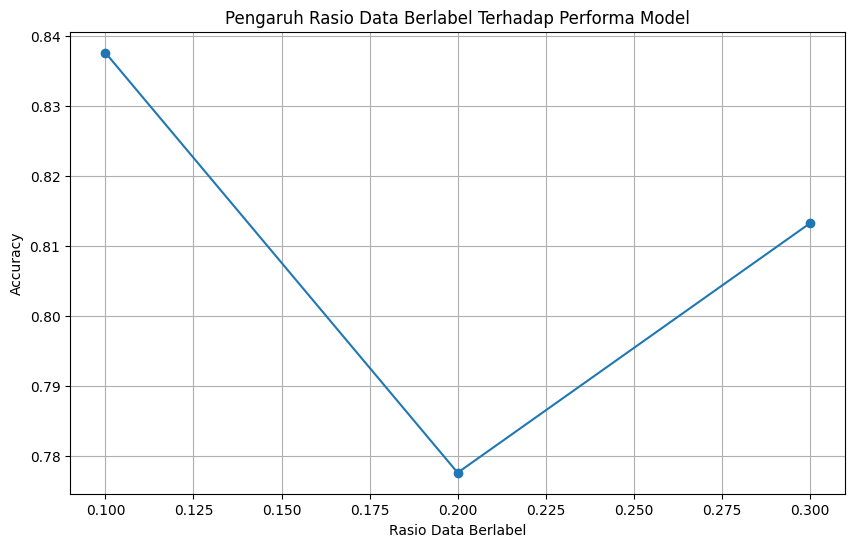


===== EKSPERIMEN 2: DAMPAK JUMLAH CLIENTS =====

Jumlah clients: 2

Distribusi Data per Client (Stratified):
Client 1:
  Data berlabel: 21230
  Data tidak berlabel: 49535
  Distribusi label:
Label
Non-Tor    14003
NonVPN      3570
VPN         3442
Tor          215
Name: count, dtype: int64

Client 2:
  Data berlabel: 21229
  Data tidak berlabel: 49536
  Distribusi label:
Label
Non-Tor    14003
NonVPN      3570
VPN         3442
Tor          214
Name: count, dtype: int64



===== FEDERATED ROUND 1/5 =====

=== Client 1 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.2305, Val Acc: 0.9124
Epoch 10/20, Loss: 0.1913, Val Acc: 0.9376
Epoch 15/20, Loss: 0.1715, Val Acc: 0.9418
Epoch 20/20, Loss: 0.1570, Val Acc: 0.9442

Iteration 1/2 of pseudo-labeling
Generated 45004 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0562, Val Acc: 0.9442
Epoch 10/20, Loss: 0.0526, Val Acc: 0.9437
Epoch 15/20, Loss: 0.0508, Val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training initial model on labeled data only...
Epoch 5/20, Loss: 0.2369, Val Acc: 0.9126
Epoch 10/20, Loss: 0.1897, Val Acc: 0.9364
Epoch 15/20, Loss: 0.1730, Val Acc: 0.9425
Epoch 20/20, Loss: 0.1564, Val Acc: 0.9430

Iteration 1/2 of pseudo-labeling
Generated 45281 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0570, Val Acc: 0.9407
Epoch 10/20, Loss: 0.0529, Val Acc: 0.9465
Epoch 15/20, Loss: 0.0509, Val Acc: 0.9451
Epoch 20/20, Loss: 0.0493, Val Acc: 0.9421

Iteration 2/2 of pseudo-labeling
Generated 46382 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0512, Val Acc: 0.9480
Epoch 10/20, Loss: 0.0493, Val Acc: 0.9461
Epoch 15/20, Loss: 0.0494, Val Acc: 0.9437
Epoch 20/20, Loss: 0.0498, Val Acc: 0.9456
Client 1 accuracy on test set: 0.8234

=== Client 2 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.2205, Val Acc: 0.9385
Epoch 10/20, Loss: 0.1837,

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training initial model on labeled data only...
Epoch 5/20, Loss: 0.2405, Val Acc: 0.9258
Epoch 10/20, Loss: 0.1958, Val Acc: 0.9435
Epoch 15/20, Loss: 0.1751, Val Acc: 0.9470
Epoch 20/20, Loss: 0.1615, Val Acc: 0.9488

Iteration 1/2 of pseudo-labeling
Generated 30306 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0611, Val Acc: 0.9452
Epoch 10/20, Loss: 0.0600, Val Acc: 0.9463
Epoch 15/20, Loss: 0.0543, Val Acc: 0.9481
Epoch 20/20, Loss: 0.0538, Val Acc: 0.9463

Iteration 2/2 of pseudo-labeling
Generated 30846 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0537, Val Acc: 0.9488
Epoch 10/20, Loss: 0.0485, Val Acc: 0.9474
Epoch 15/20, Loss: 0.0534, Val Acc: 0.9505
Epoch 20/20, Loss: 0.0481, Val Acc: 0.9488
Client 1 accuracy on test set: 0.9004

=== Client 2 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.2605, Val Acc: 0.9057
Epoch 10/20, Loss: 0.2174,

KeyboardInterrupt: 

In [ ]:
# 9. Jalankan Semua Eksperimen dan Federated Semi-Supervised Learning

def run_all_experiments():
    # Jalankan eksperimen dari #5
    experiment_label_ratio()
    experiment_num_clients()
    experiment_data_distribution()
    experiment_adaptability()

    # Siapkan data untuk Federated Learning
    print("\n===== EKSPERIMEN UTAMA: FEDERATED SEMI-SUPERVISED LEARNING =====")

    # Menggunakan dataset yang sudah dibersihkan
    labeled_data = pd.read_csv('labeled_data.csv')
    unlabeled_data = pd.read_csv('unlabeled_data.csv')

    # Membagi data ke dalam klien
    num_clients = 10  # Bisa disesuaikan sesuai eksperimen

    labeled_clients, unlabeled_clients = simulate_federated_clients_stratified(
        labeled_data, unlabeled_data, num_clients=num_clients
    )

    # Tetapkan parameter
    num_federated_rounds = 10  # Maksimum 10 round
    print(f"Jumlah round: {num_federated_rounds}")
    print(f"Jumlah clients: {num_clients}")

    start_time = time.time()

    # Jalankan Federated Semi-Supervised Learning
    final_weights, global_accuracy, client_accuracies = run_federated_semi_supervised_learning(
        labeled_clients, unlabeled_clients,
        num_federated_rounds=num_federated_rounds,
        num_clients=num_clients
    )

    total_time = time.time() - start_time
    print(f"\nTotal waktu eksekusi: {total_time:.2f} detik")

run_all_experiments()

<Figure size 1200x800 with 0 Axes>

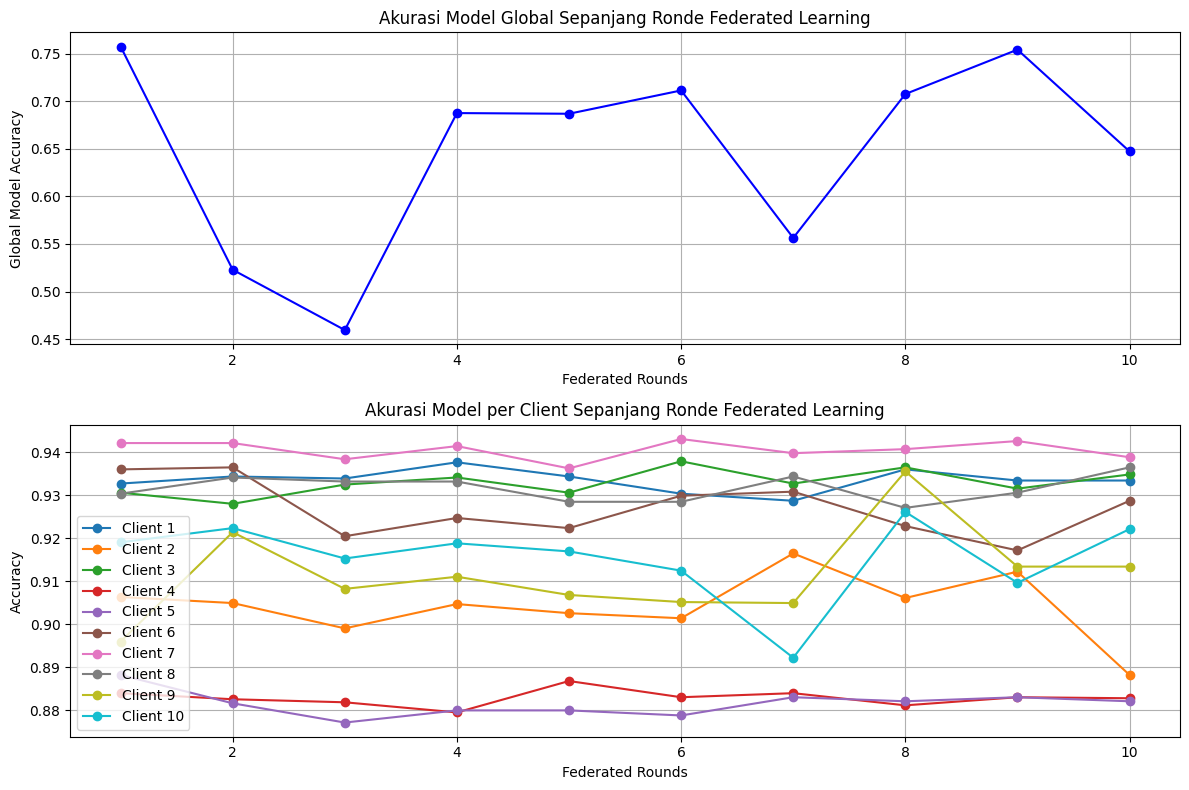


Statistik Hasil Federated Learning:
Akurasi akhir model global: 0.6472
Rata-rata akurasi client: 0.9161
Standar deviasi akurasi client: 0.0220
Akurasi client tertinggi: 0.9388
Akurasi client terendah: 0.8821


In [ ]:
# 10. Visualisasi Hasil Federated Learning

# Visualisasi hasil
plt.figure(figsize=(12, 8))

plt.figure(figsize=(12, 8))
# 1. Plot global accuracy over rounds
plt.subplot(2, 1, 1)
plt.plot(range(1, len(global_accuracy)+1), global_accuracy, marker='o', linestyle='-', color='blue')
plt.xlabel('Federated Rounds')
plt.ylabel('Global Model Accuracy')
plt.title('Akurasi Model Global Sepanjang Ronde Federated Learning')
plt.grid(True)

# 2. Plot client accuracies
plt.subplot(2, 1, 2)
for i, client_acc in enumerate(client_accuracies):
    if len(client_acc) > 0:  # Beberapa client mungkin tidak memiliki data
        plt.plot(range(1, len(client_acc)+1), client_acc, marker='o', linestyle='-',
                label=f'Client {i+1}')

plt.xlabel('Federated Rounds')
plt.ylabel('Accuracy')
plt.title('Akurasi Model per Client Sepanjang Ronde Federated Learning')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('federated_learning_results.png')
plt.show()

# Tampilkan statistik hasil
print("\nStatistik Hasil Federated Learning:")
print(f"Akurasi akhir model global: {global_accuracy[-1]:.4f}")

# Hitung rata-rata dan standar deviasi akurasi client
client_final_accs = [acc[-1] for acc in client_accuracies if len(acc) > 0]
if client_final_accs:
    print(f"Rata-rata akurasi client: {np.mean(client_final_accs):.4f}")
    print(f"Standar deviasi akurasi client: {np.std(client_final_accs):.4f}")
    print(f"Akurasi client tertinggi: {np.max(client_final_accs):.4f}")
    print(f"Akurasi client terendah: {np.min(client_final_accs):.4f}")

In [ ]:
# 11. Jalankan Perbandingan Algoritma Agregasi

print("\n\n===== PERBANDINGAN ALGORITMA AGREGASI =====")
aggregation_results = experiment_aggregation_algorithms()  # Change variable name here

# Tampilkan hasil terbaik
top_algorithm = max(
    [(algo, res['global_accuracy'][-1] if res['global_accuracy'] else 0)
     for algo, res in aggregation_results.items()],
    key=lambda x: x[1]
)

print(f"\nAlgoritma Agregasi Terbaik: {top_algorithm[0]} dengan akurasi {top_algorithm[1]:.4f}")



===== PERBANDINGAN ALGORITMA AGREGASI =====

===== EKSPERIMEN: PERBANDINGAN ALGORITMA AGREGASI =====
Menggunakan dataset yang sudah dibersihkan: Darknet_cleaned.csv
Dataset berhasil dimuat dengan 141530 baris dan 85 kolom

=== Menjalankan FedAvg ===

Distribusi Data per Client (Stratified):
Client 1:
  Data berlabel: 8492
  Data tidak berlabel: 19814
  Distribusi label:
Label
Non-Tor    5602
NonVPN     1428
VPN        1377
Tor          85
Name: count, dtype: int64

Client 2:
  Data berlabel: 8492
  Data tidak berlabel: 19814
  Distribusi label:
Label
Non-Tor    5601
NonVPN     1428
VPN        1377
Tor          86
Name: count, dtype: int64

Client 3:
  Data berlabel: 8492
  Data tidak berlabel: 19814
  Distribusi label:
Label
Non-Tor    5601
NonVPN     1428
VPN        1377
Tor          86
Name: count, dtype: int64

Client 4:
  Data berlabel: 8492
  Data tidak berlabel: 19814
  Distribusi label:
Label
Non-Tor    5601
NonVPN     1428
VPN        1377
Tor          86
Name: count, dtype: i

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/20, Loss: 0.2798, Val Acc: 0.9152
Epoch 10/20, Loss: 0.2131, Val Acc: 0.9388
Epoch 15/20, Loss: 0.1914, Val Acc: 0.9388
Epoch 20/20, Loss: 0.1696, Val Acc: 0.9417

Iteration 1/2 of pseudo-labeling
Generated 18029 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0610, Val Acc: 0.9417
Epoch 10/20, Loss: 0.0598, Val Acc: 0.9400
Epoch 15/20, Loss: 0.0582, Val Acc: 0.9429
Epoch 20/20, Loss: 0.0543, Val Acc: 0.9376

Iteration 2/2 of pseudo-labeling
Generated 18501 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0523, Val Acc: 0.9411
Epoch 10/20, Loss: 0.0501, Val Acc: 0.9417
Epoch 15/20, Loss: 0.0524, Val Acc: 0.9435
Epoch 20/20, Loss: 0.0491, Val Acc: 0.9435
Client 1 accuracy on test set: 0.8671

=== Client 2 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.2961, Val Acc: 0.8970
Epoch 10/20, Loss: 0.2400, Val Acc: 0.9099
Epoch 15/20, Loss: 0.2211, Val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/20, Loss: 0.2875, Val Acc: 0.8941
Epoch 10/20, Loss: 0.2132, Val Acc: 0.9258
Epoch 15/20, Loss: 0.1877, Val Acc: 0.9358
Epoch 20/20, Loss: 0.1667, Val Acc: 0.9429

Iteration 1/2 of pseudo-labeling
Generated 17941 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0612, Val Acc: 0.9406
Epoch 10/20, Loss: 0.0579, Val Acc: 0.9411
Epoch 15/20, Loss: 0.0556, Val Acc: 0.9376
Epoch 20/20, Loss: 0.0523, Val Acc: 0.9411

Iteration 2/2 of pseudo-labeling
Generated 18524 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0585, Val Acc: 0.9453
Epoch 10/20, Loss: 0.0522, Val Acc: 0.9411
Epoch 15/20, Loss: 0.0494, Val Acc: 0.9435
Epoch 20/20, Loss: 0.0486, Val Acc: 0.9447
Client 1 accuracy on test set: 0.8667

=== Client 2 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.3008, Val Acc: 0.8899
Epoch 10/20, Loss: 0.2398, Val Acc: 0.9111
Epoch 15/20, Loss: 0.2186, Val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/20, Loss: 0.2717, Val Acc: 0.8952
Epoch 10/20, Loss: 0.2218, Val Acc: 0.9358
Epoch 15/20, Loss: 0.1905, Val Acc: 0.9364
Epoch 20/20, Loss: 0.1717, Val Acc: 0.9353

Iteration 1/2 of pseudo-labeling
Generated 17777 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0627, Val Acc: 0.9429
Epoch 10/20, Loss: 0.0565, Val Acc: 0.9423
Epoch 15/20, Loss: 0.0546, Val Acc: 0.9447
Epoch 20/20, Loss: 0.0562, Val Acc: 0.9447

Iteration 2/2 of pseudo-labeling
Generated 18416 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0548, Val Acc: 0.9476
Epoch 10/20, Loss: 0.0544, Val Acc: 0.9441
Epoch 15/20, Loss: 0.0505, Val Acc: 0.9447
Epoch 20/20, Loss: 0.0475, Val Acc: 0.9423
Client 1 accuracy on test set: 0.8716

=== Client 2 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.3026, Val Acc: 0.8982
Epoch 10/20, Loss: 0.2433, Val Acc: 0.9076
Epoch 15/20, Loss: 0.2210, Val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/20, Loss: 0.2823, Val Acc: 0.8964
Epoch 10/20, Loss: 0.2156, Val Acc: 0.9282
Epoch 15/20, Loss: 0.1901, Val Acc: 0.9347
Epoch 20/20, Loss: 0.1756, Val Acc: 0.9364

Iteration 1/2 of pseudo-labeling
Generated 17782 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0621, Val Acc: 0.9417
Epoch 10/20, Loss: 0.0578, Val Acc: 0.9400
Epoch 15/20, Loss: 0.0581, Val Acc: 0.9388
Epoch 20/20, Loss: 0.0535, Val Acc: 0.9394

Iteration 2/2 of pseudo-labeling
Generated 18392 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0522, Val Acc: 0.9435
Epoch 10/20, Loss: 0.0475, Val Acc: 0.9406
Epoch 15/20, Loss: 0.0484, Val Acc: 0.9435
Epoch 20/20, Loss: 0.0502, Val Acc: 0.9476
Client 1 accuracy on test set: 0.8728

=== Client 2 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.2871, Val Acc: 0.8946
Epoch 10/20, Loss: 0.2327, Val Acc: 0.9088
Epoch 15/20, Loss: 0.2180, Val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




===== FEDERATED ROUND 1/5 =====

=== Client 1 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.2742, Val Acc: 0.9270
Epoch 10/20, Loss: 0.2168, Val Acc: 0.9394
Epoch 15/20, Loss: 0.1899, Val Acc: 0.9411
Epoch 20/20, Loss: 0.1748, Val Acc: 0.9417

Iteration 1/2 of pseudo-labeling
Generated 17796 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0675, Val Acc: 0.9423
Epoch 10/20, Loss: 0.0569, Val Acc: 0.9417
Epoch 15/20, Loss: 0.0557, Val Acc: 0.9429
Epoch 20/20, Loss: 0.0554, Val Acc: 0.9417

Iteration 2/2 of pseudo-labeling
Generated 18376 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0554, Val Acc: 0.9300
Epoch 10/20, Loss: 0.0524, Val Acc: 0.9423
Epoch 15/20, Loss: 0.0502, Val Acc: 0.9406
Epoch 20/20, Loss: 0.0475, Val Acc: 0.9423
Client 1 accuracy on test set: 0.8728

=== Client 2 Training ===
Training initial model on labeled data only...
Epoch 5

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/20, Loss: 0.2834, Val Acc: 0.9058
Epoch 10/20, Loss: 0.2099, Val Acc: 0.9247
Epoch 15/20, Loss: 0.1828, Val Acc: 0.9376
Epoch 20/20, Loss: 0.1753, Val Acc: 0.9376

Iteration 1/2 of pseudo-labeling
Generated 17676 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0636, Val Acc: 0.9394
Epoch 10/20, Loss: 0.0552, Val Acc: 0.9388
Epoch 15/20, Loss: 0.0600, Val Acc: 0.9364
Epoch 20/20, Loss: 0.0524, Val Acc: 0.9406

Iteration 2/2 of pseudo-labeling
Generated 18445 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0554, Val Acc: 0.9400
Epoch 10/20, Loss: 0.0483, Val Acc: 0.9411
Epoch 15/20, Loss: 0.0514, Val Acc: 0.9417
Epoch 20/20, Loss: 0.0492, Val Acc: 0.9435
Client 1 accuracy on test set: 0.8660

=== Client 2 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.2987, Val Acc: 0.8929
Epoch 10/20, Loss: 0.2470, Val Acc: 0.9123
Epoch 15/20, Loss: 0.2207, Val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/20, Loss: 0.2645, Val Acc: 0.9111
Epoch 10/20, Loss: 0.2101, Val Acc: 0.9317
Epoch 15/20, Loss: 0.1909, Val Acc: 0.9388
Epoch 20/20, Loss: 0.1732, Val Acc: 0.9417

Iteration 1/2 of pseudo-labeling
Generated 17947 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0632, Val Acc: 0.9353
Epoch 10/20, Loss: 0.0551, Val Acc: 0.9358
Epoch 15/20, Loss: 0.0548, Val Acc: 0.9423
Epoch 20/20, Loss: 0.0505, Val Acc: 0.9382

Iteration 2/2 of pseudo-labeling
Generated 18444 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0493, Val Acc: 0.9382
Epoch 10/20, Loss: 0.0498, Val Acc: 0.9388
Epoch 15/20, Loss: 0.0508, Val Acc: 0.9400
Epoch 20/20, Loss: 0.0497, Val Acc: 0.9429
Client 1 accuracy on test set: 0.8695

=== Client 2 Training ===
Training initial model on labeled data only...
Epoch 5/20, Loss: 0.3082, Val Acc: 0.8917
Epoch 10/20, Loss: 0.2470, Val Acc: 0.9094
Epoch 15/20, Loss: 0.2175, Val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/20, Loss: 0.2797, Val Acc: 0.9005
Epoch 10/20, Loss: 0.2205, Val Acc: 0.9388
Epoch 15/20, Loss: 0.1913, Val Acc: 0.9364
Epoch 20/20, Loss: 0.1758, Val Acc: 0.9376

Iteration 1/2 of pseudo-labeling
Generated 17912 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...
Epoch 5/20, Loss: 0.0642, Val Acc: 0.9406
Epoch 10/20, Loss: 0.0573, Val Acc: 0.9423
Epoch 15/20, Loss: 0.0546, Val Acc: 0.9411
Epoch 20/20, Loss: 0.0531, Val Acc: 0.9411

Iteration 2/2 of pseudo-labeling
Generated 18497 confident pseudo-labels
Training on combined data (labeled + pseudo-labeled)...


KeyboardInterrupt: 


Evaluasi Model Final (Algoritma: FedKrum):
Accuracy: 0.9484
Precision: 0.9477
Recall: 0.9484
F1 Score: 0.9479


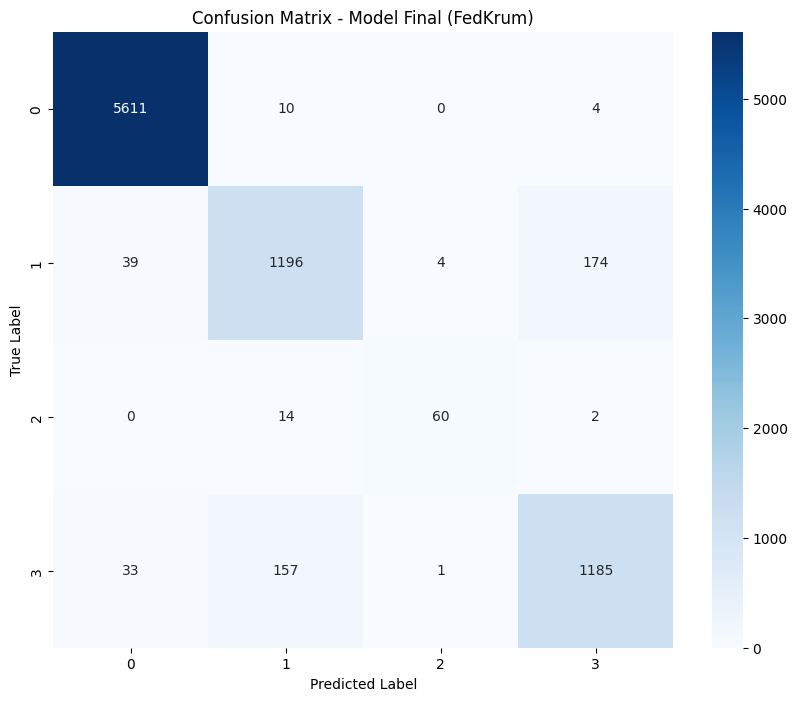

In [ ]:
# 12. Evaluasi Model dengan Algoritma Terbaik

# Gunakan algoritma agregasi terbaik untuk menyiapkan model final
best_algo = top_algorithm[0]
best_weights = aggregation_results[best_algo]['weights']

# Siapkan data test
test_data = pd.concat([client.sample(frac=0.2) for client in labeled_clients if len(client) > 0])
X_test = prepare_features(test_data)
y_test = test_data['Label'].values
le = LabelEncoder()
y_test = le.fit_transform(y_test)

X_test, test_scaler = preprocess_data(X_test)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Inisialisasi model dengan bobot terbaik
final_model = DarknetClassifier(
    input_dim=X_test.shape[1],
    hidden_dim=128,
    output_dim=len(np.unique(y_test))
)
final_model.set_weights(best_weights)
final_model.eval()

# Evaluasi model final
with torch.no_grad():
    outputs = final_model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted = predicted.numpy()
    y_true = y_test_tensor.numpy()

    # Hitung metrik evaluasi
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

    accuracy = accuracy_score(y_true, predicted)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, predicted, average='weighted')
    conf_matrix = confusion_matrix(y_true, predicted)

    print(f"\nEvaluasi Model Final (Algoritma: {best_algo}):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Visualisasi confusion matrix
    plt.figure(figsize=(10, 8))
    import seaborn as sns
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Model Final ({best_algo})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('final_model_confusion_matrix.png')
    plt.show()

In [ ]:
# 13. Simpan Model dan Hasil

import pickle
import os
from datetime import datetime

# Buat direktori untuk menyimpan hasil jika belum ada
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

# Buat timestamp untuk nama file
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Simpan model terbaik
model_file = f"{results_dir}/darknet_model_{best_algo}_{timestamp}.pkl"
with open(model_file, 'wb') as f:
    pickle.dump(best_weights, f)

# Simpan hasil eksperimen
results_file = f"{results_dir}/experiment_results_{timestamp}.pkl"
experiment_results = {
    'fedavg_results': {
        'global_accuracy': global_accuracy,
        'client_accuracies': client_accuracies
    },
    'aggregation_comparison': aggregation_results,
    'best_algorithm': best_algo,
    'evaluation_metrics': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    },
    'experiment_params': {
        'num_clients': num_clients,
        'num_rounds': num_federated_rounds,
        'labeled_ratio': 1 - unlabeled_ratio
    }
}

with open(results_file, 'wb') as f:
    pickle.dump(experiment_results, f)

print(f"\nModel terbaik disimpan ke: {model_file}")
print(f"Hasil eksperimen disimpan ke: {results_file}")
print("\nEksperimen selesai!")


Model terbaik disimpan ke: results/darknet_model_FedKrum_20250427_112001.pkl
Hasil eksperimen disimpan ke: results/experiment_results_20250427_112001.pkl

Eksperimen selesai!
